# **SW07: Regularized Regression Methods**

Regularization can help to reduce overfitting in regression or logistic regression models.
In this notebook, we briefly explore the effect of regularization.

---


In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error

# Some Jupyter magic for nicer output
%config InlineBackend.figure_formats = ["svg"]   # Enable vectorized graphics

# Adjust the default settings for plots
import sys
sys.path.append("..")
import ml
ml.setup_plotting()

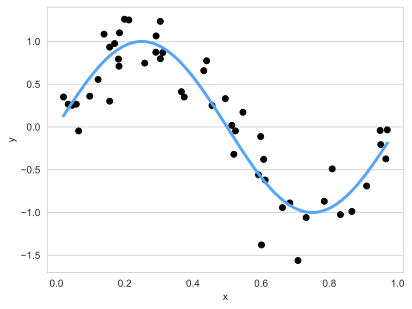

In [2]:
# Let's generate some data for regression
n_samples = 50
noise = 0.3
seed = 42

def f(x):
    return np.sin(2 * np.pi * x)

def generate_data(n_samples, noise, seed, fun=None):
    np.random.seed(seed)
    x = np.sort(np.random.rand(n_samples))
    y = fun(x) + np.random.randn(n_samples) * noise
    X = x[:, np.newaxis]
    return X, y

X_train, y_train = generate_data(n_samples, noise, seed=42, fun=f)
X_test, y_test = generate_data(n_samples*10, noise, seed=43, fun=f)

# Let's also visualize the data
X_gt = np.linspace(X_train.min(), X_train.max(), 1000)
y_gt = f(X_gt)

plt.scatter(X_train, y_train, color='black')
plt.plot(X_gt, y_gt, linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(axis="x")
plt.show()

In [3]:
def add_info_box(ax, degree, score_train, score_test,):
    """Add a text box with information about the model to the plot.
    """
    
    info = r"Degree: %-3d" % degree
    info += "\n" + r"$MSE_{train}$: %.2g" % score_train
    info += "\n" + r"$MSE_{test}$: %.2g" % score_test
    
    # Set widht of the text box
    axes[i].text(0.55, 1.50, info, 
                 horizontalalignment='left',
                 verticalalignment='top', 
                 zorder=10000,
                 fontsize=7,
                 usetex=False,
                 bbox=dict(facecolor='white', 
                           alpha=0.8,
                           edgecolor='black', 
                           boxstyle='round,pad=0.3'))

a = 1

In [4]:
# Let's train a range of polynomial regression models, with and 
# without regularization
degrees = np.array([2, 3, 4, 10, 50, 100])
models_plain = []
models_ridge = []
models_lasso = []

scores_train = []
scores_test = []


def train_test_model(regressor, degree, X_train, y_train, X_test, y_test):
    model = make_pipeline(PolynomialFeatures(degree), regressor)
    model.fit(X_train, y_train)
    score_train = mean_squared_error(y_train, model.predict(X_train))
    score_test = mean_squared_error(y_test, model.predict(X_test))
    return model, score_train, score_test

# Train and collect the performance of the models.
for i, degree in enumerate(degrees):
    
    info = train_test_model(LinearRegression(), degree, 
                            X_train, y_train, 
                            X_test, y_test)
    models_plain.append(info)


    info = train_test_model(Ridge(alpha=1e-3), 
                            degree, 
                            X_train, y_train, 
                            X_test, y_test)
    models_ridge.append(info)
    
    info = train_test_model(Lasso(alpha=1e-3, max_iter=10000), 
                            degree, 
                            X_train, y_train, 
                            X_test, y_test)
    models_lasso.append(info)

Degree: 2
       MSE train    MSE test
Plain:      0.27        0.31
Ridge:      0.27        0.31
Lasso:      0.27        0.31

Degree: 3
       MSE train    MSE test
Plain:     0.079       0.091
Ridge:      0.08        0.10
Lasso:      0.11        0.12

Degree: 4
       MSE train    MSE test
Plain:     0.076       0.097
Ridge:      0.08        0.10
Lasso:      0.09        0.10

Degree: 10
       MSE train    MSE test
Plain:     0.061        0.12
Ridge:      0.07        0.09
Lasso:      0.09        0.12

Degree: 50
       MSE train    MSE test
Plain:     0.041     1.2e+07
Ridge:      0.07        0.10
Lasso:      0.09        0.12

Degree: 100
       MSE train    MSE test
Plain:     0.039     3.5e+12
Ridge:      0.07        0.45
Lasso:      0.09        0.12



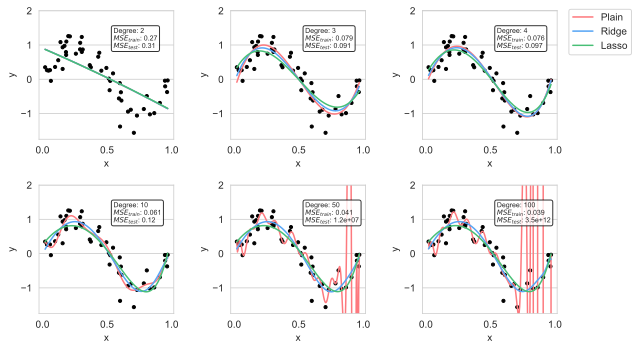

In [5]:
h, w = degrees.size // 3, 3
fig, axes = plt.subplots(h, w, figsize=(9, h*2.5))
axes = axes.flatten()

blue,red,green = ml.PALETTE[:3]

# Plot the models    
for i, degree in enumerate(degrees):
    
    print(f"Degree: {degree}")
    print("       MSE train    MSE test")
        
    
    axes[i].scatter(X_train, y_train, color="black", s=10)
    #axes[i].scatter(X_test, y_test, marker=".", color='blue')
    
    model, score_train, score_test = models_plain[i]
    x = np.linspace(X_train.min(), X_train.max(), 200)
    axes[i].plot(x, model.predict(x[:, np.newaxis]), color=red, label="Plain")  
    add_info_box(ax=axes[i], degree=degree, 
                 score_train=score_train, 
                 score_test=score_test)
    print(f"Plain:   {score_train:7.2g}     {score_test:7.2g}")
    
    model, score_train, score_test = models_ridge[i]
    axes[i].plot(x, model.predict(x[:, np.newaxis]), color=blue, label="Ridge") 
    print(f"Ridge:   {score_train:7.2f}     {score_test:7.2f}") 
    
    model, score_train, score_test = models_lasso[i]
    axes[i].plot(x, model.predict(x[:, np.newaxis]), color=green, label="Lasso")
    print(f"Lasso:   {score_train:7.2f}     {score_test:7.2f}")
    print()
    
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].grid(axis="x")
    axes[i].set_ylim([-1.75, 2.0]) 
    

# Legend outside the plot
axes[2].legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))
fig.tight_layout(w_pad=2)

**Observations**:
- Regularization can help to reduce overfitting by penalizing large coefficients.
- The linear regression model has a high variance and low bias, which results in overfitting.
- The ridge and lasso regression model have a lower variance and higher bias, which results in underfitting.
- The parameter α controls the strength of the regularization.
- It is a hyperparameter that needs to be tuned. It can be found using cross-validation and grid search.




Best alpha: 0.0017
Best score: -0.098


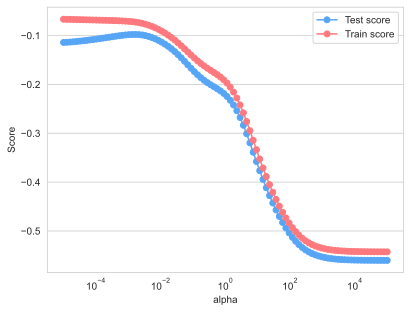

In [6]:
# Demonstration of a hyperparameter search for Ridge regression:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# The values of alpha to search
alphas = np.logspace(-5, 5, 100)

# We use here the Pipeline object to chain together the PolynomialFeatures
# and Ridge regression objects. In contrast to make_pipeline(), we can give 
# the steps names, which is useful when we want to address the parameters of 
# the steps in the grid search.
pipeline = Pipeline([("poly", PolynomialFeatures(degree=30)), 
                     ("ridge", Ridge())])

# The parameter grid is a dictionary with the parameter
# names as keys and the values to search as values
# We can address parameters of the different stages of the pipeline
# using the double underscore "__" separator: "ridge__alpha"
param_grid = {"ridge__alpha": alphas}

# Run the grid search with 5-fold cross-validation.
# Use the MSE as the scoring metric, or "neg_mean_squared_error"
# because GridSearchCV always maximizes the score..!
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline,
                    param_grid, cv=kf, return_train_score=True,
                    scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

# Let's print the best alpha and the best score
print(f"Best alpha: {grid.best_params_['ridge__alpha']:.2g}")
print(f"Best score: {grid.best_score_:.2g}")

# Plot the results of the cross-validation
plt.figure()
plt.semilogx(alphas, grid.cv_results_["mean_test_score"], "-o", label="Test score")
plt.semilogx(alphas, grid.cv_results_["mean_train_score"], "-o", label="Train score")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="x")
plt.show()